In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from matplotlib import pyplot as plt
%matplotlib inline 
xp = cuda.cupy
import time


def model_func(model):
    if xp == np:
        pass
    else :
        gpu_device = 0
        cuda.get_device(gpu_device).use()
        model.to_gpu(gpu_device)
xp.model_init = model_func
xp.pi = np.pi

In [2]:
from chainer.utils import type_check
class ELU(Function):

    """Exponential Linear Unit."""
    # https://github.com/muupan/chainer-elu

    def __init__(self, alpha=1.0):
        self.alpha = xp.float32(alpha)

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 1)
        x_type, = in_types

        type_check.expect(
            x_type.dtype == xp.float32,
        )

    def forward_cpu(self, x):
        y = x[0].copy()
        neg_indices = x[0] < 0
        y[neg_indices] = self.alpha * (xp.exp(y[neg_indices]) - 1)
        return y,

    def forward_gpu(self, x):
        y = cuda.elementwise(
            'T x, T alpha', 'T y',
            'y = x >= 0 ? x : alpha * (exp(x) - 1)', 'elu_fwd')(
                x[0], self.alpha)
        return y,

    def backward_cpu(self, x, gy):
        gx = gy[0].copy()
        neg_indices = x[0] < 0
        gx[neg_indices] *= self.alpha * xp.exp(x[0][neg_indices])
        return gx,

    def backward_gpu(self, x, gy):
        gx = cuda.elementwise(
            'T x, T gy, T alpha', 'T gx',
            'gx = x >= 0 ? gy : gy * alpha * exp(x)', 'elu_bwd')(
                x[0], gy[0], self.alpha)
        return gx,


def elu(x, alpha=1.0):
    """Exponential Linear Unit function."""
    # https://github.com/muupan/chainer-elu
    return ELU(alpha=alpha)(x)


In [3]:
train,test = chainer.datasets.get_mnist()

In [4]:
dat = xp.array([ it[0] for it in train ]).astype(np.float32)

In [5]:
def get_dat(dat,size = 50):
    N = dat.shape[0]
    r = np.random.randint(N//50)
    return dat[r*size:(r+1)*size].reshape(-1,1,28,28)

In [6]:
nz = 5
class Gen(Chain):
    def __init__(this):
        super().__init__(
            l1 = L.Linear(nz,128*4*4),
            c7 = L.Deconvolution2D(128,64,3,stride=2,pad = 1),
            c8 = L.Deconvolution2D(64,32,4,stride=2,pad=1),
            c9 = L.Deconvolution2D(32,8,4,stride=2,pad=1),
            ce1= L.Deconvolution2D(8,8,3,stride=1,pad=1),
            ce2= L.Deconvolution2D(8,1,3,stride=1,pad=1),
            
        )
    
    def __call__(this,x):
        h = this.l1(x)
        h = F.reshape(h,(h.data.shape[0],128,4,4))
        #print ( h.data.shape)
        h = this.c7(elu(h))
        h = this.c8(elu(h))
        #print ( h.data.shape)
        h = this.c9(elu(h))
        h = this.ce1(elu(h))
        y = this.ce2(elu(h))
        #print ( y.data.shape)
        return y

class Dis(Chain):
    def __init__(this):
        super().__init__(
            c0 = L.Convolution2D(1,32,4,stride=2,pad=1),
            c1 = L.Convolution2D(32,64,4,stride=2,pad=1),
            c2 = L.Convolution2D(64,128,3,stride=2,pad=1),
            l2 = L.Linear(128*4*4 + 2, 64),
            l3 = L.Linear(64,3),
        )
    def __call__(this,x):
        N = x.data.shape[0]
        h = F.reshape(x,(N,1,28,28))
        h = this.c0(h)
        h = this.c1(elu(h))
        h = this.c2(elu(h))
        h = F.reshape(h,(N,-1))
        #print (h.data.shape)
        B = F.expand_dims(h,2)
        BT= F.transpose(B,(2,1,0))
        B,BT = F.broadcast(B,BT)
        ab1= F.absolute(B-BT) 
        ab2= (B-BT)*0
        #print ("ab",ab.shape)
        n1 = F.sum(ab1,axis = (1,2)).reshape(N,1)
        n2 = F.sum(ab2,axis = (1,2)).reshape(N,1)
        #print (norm.shape)
        h = F.concat( ( h,n1,n2 ) , axis = 1 )
        #print (h.shape)
        h = this.l2(elu(h))
        y = this.l3(elu(h))
        return y  
gen = Gen()
dis = Dis()

xp.model_init(gen)
xp.model_init(dis)


o_gen = optimizers.Adam()
o_gen.setup(gen)
o_gen.add_hook(chainer.optimizer.WeightDecay(0.0001))

o_dis = optimizers.Adam()
o_dis.setup(dis)
o_dis.add_hook(chainer.optimizer.WeightDecay(0.0001))

/nfs/home/endo/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/chainer/cuda.py:92: UserWarning: cuDNN is not enabled.
Please reinstall chainer after you install cudnn
(see https://github.com/pfnet/chainer#installation).
  'cuDNN is not enabled.\n'


In [7]:
stp = 1000 * 10
prt = 500
size = 50

for i in range(stp):
    
    z = Variable(xp.random.uniform(-1,1,(size,nz),dtype=np.float32))
    x = gen(z)
    y = dis(x)
    L_gen = F.softmax_cross_entropy(y,Variable(xp.zeros(size,dtype=np.int32)))
    L_dis = F.softmax_cross_entropy(y,Variable(xp.ones (size,dtype=np.int32)))
    
    x2 = Variable(get_dat(dat,size))
    y2= dis(x2) 
    L_dis+= F.softmax_cross_entropy(y2,Variable(xp.zeros(size,dtype=np.int32))) 
    
    gen.cleargrads()
    L_gen.backward()
    o_gen.update()
    
    dis.cleargrads()
    L_dis.backward()
    o_dis.update()
    
    if i % prt == 0:
        print ("{},{},{}".format(i,L_gen.data,L_dis.data))

0,863.2471923828125,525.6530151367188
500,0.7634472250938416,36.274192810058594
1000,0.0012390136253088713,23.099916458129883
1500,0.11461242288351059,3.4613499641418457
2000,0.6705950498580933,1.7616827487945557
2500,0.5732839703559875,2.1738321781158447
3000,1.5125566720962524,1.0636166334152222
3500,6.620309829711914,2.534636974334717
4000,4.563570976257324,2.6432712078094482
4500,1.1225707530975342,0.7194686532020569
5000,2.1262848377227783,0.4362165927886963
5500,5.70896577835083,0.36457520723342896
6000,31.887235641479492,0.7734359502792358
6500,11.76802921295166,0.4250463843345642
7000,19.033435821533203,0.008913726545870304
7500,3.317598819732666,0.6909435987472534
8000,1.7419674396514893,0.470172256231308
8500,1.5769420862197876,0.5848748683929443
9000,7.439655780792236,0.7939861416816711
9500,0.8000404834747314,0.8664250373840332


0 [[  2.84608454e-04   2.51360595e-01   4.32096034e-01  -6.39066100e-01
   -4.39344734e-01]]


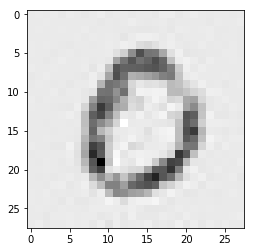

1 [[-0.0213642   0.21729031  0.37098163 -0.60686201 -0.37935746]]


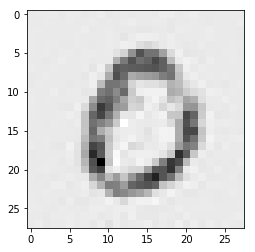

2 [[-0.03122715  0.17676172  0.31045997 -0.57377654 -0.32017437]]


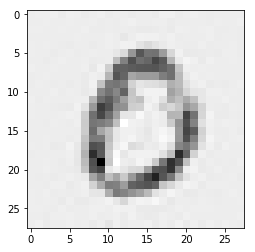

3 [[-0.03905274  0.14426412  0.24485189 -0.53499007 -0.264732  ]]


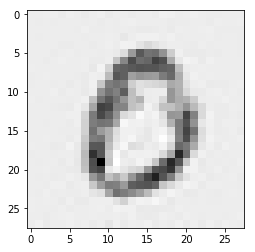

4 [[-0.04385079  0.12466673  0.18564826 -0.48297092 -0.20657824]]


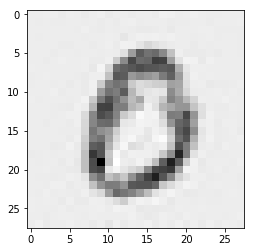

5 [[-0.04829898  0.11035274  0.12289228 -0.43020782 -0.15132368]]


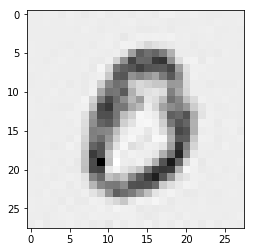

6 [[-0.0468262   0.09427326  0.05945385 -0.38110757 -0.09384314]]


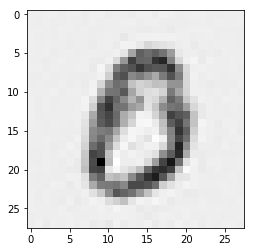

7 [[ -4.54325043e-02   7.69495964e-02  -1.31778419e-04  -3.29230577e-01
   -3.50529924e-02]]


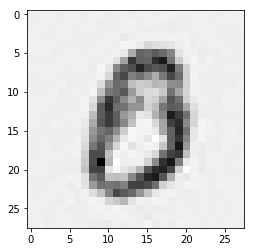

8 [[-0.04373518  0.05654275 -0.06070826 -0.27955529  0.02362865]]


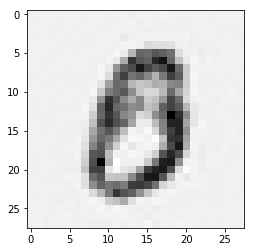

9 [[-0.05153446  0.03892274 -0.12349021 -0.23163627  0.0818601 ]]


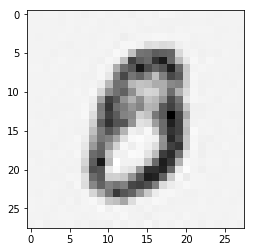

10 [[-0.06304784  0.02739296 -0.18688294 -0.17931637  0.13643569]]


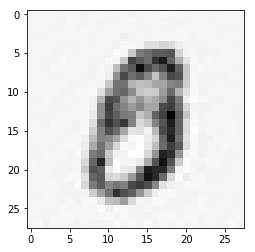

11 [[-0.06982648  0.01610903 -0.25340939 -0.13023472  0.19113438]]


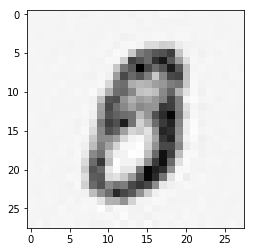

12 [[-0.08424973  0.00389677 -0.32102174 -0.08204882  0.24357022]]


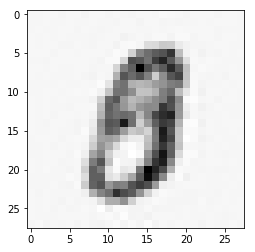

13 [[-0.10091963 -0.00647799 -0.39204127 -0.03148624  0.28844932]]


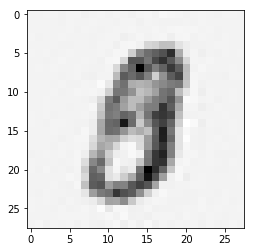

14 [[-0.1244318  -0.01798582 -0.45663035  0.02044675  0.33790597]]


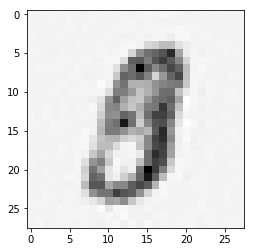

15 [[-0.14671536 -0.02371057 -0.51863241  0.07723127  0.38691548]]


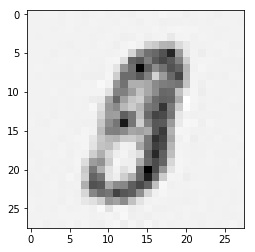

16 [[-0.17527075 -0.02997722 -0.57472479  0.13521165  0.43826956]]


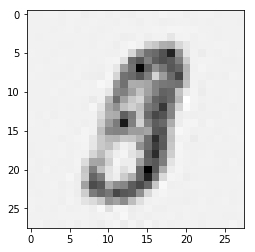

17 [[-0.19821112 -0.03277164 -0.62689877  0.19066983  0.49883521]]


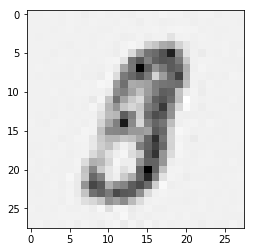

18 [[-0.2173253  -0.03552453 -0.68298244  0.25580177  0.54615879]]


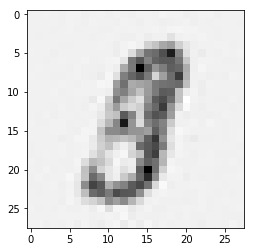

19 [[-0.2438686  -0.04620086 -0.74135625  0.31509894  0.59367526]]


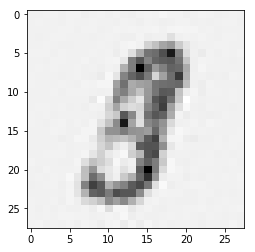

20 [[-0.27039605 -0.03948834 -0.80247015  0.36568004  0.64806169]]


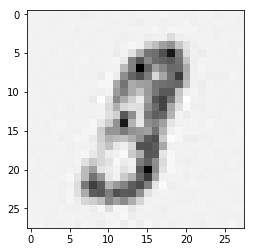

21 [[-0.30021855 -0.03029778 -0.86649561  0.41282907  0.70006037]]


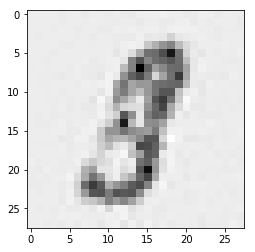

22 [[-0.32408059 -0.02670728 -0.93651581  0.46515939  0.742208  ]]


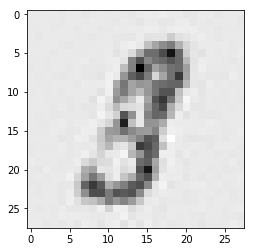

23 [[-0.34845987 -0.00680121 -1.00194144  0.47070968  0.81075054]]


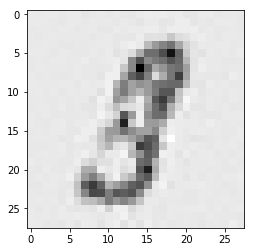

24 [[-0.34084782  0.01457465 -1.07279611  0.43156457  0.8649022 ]]


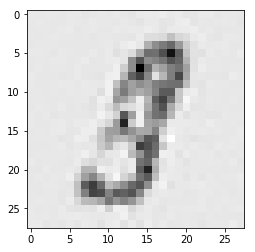

25 [[-0.38826364 -0.00787593 -0.9994393   0.40804797  0.90114391]]


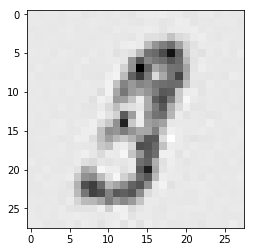

26 [[-0.40657499 -0.03633768 -0.91288918  0.41332659  0.86459476]]


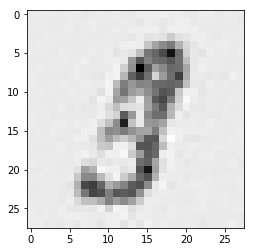

27 [[-0.41327026 -0.0562075  -0.82178676  0.39427021  0.83463526]]


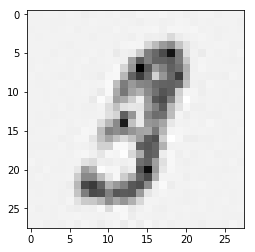

28 [[-0.41275764 -0.07763182 -0.73019803  0.38296339  0.80262917]]


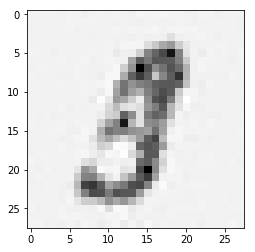

29 [[-0.4012281  -0.09664076 -0.63912296  0.37907296  0.76804692]]


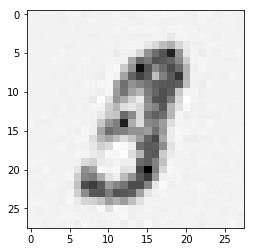

30 [[-0.38775554 -0.12532976 -0.55223352  0.37851122  0.73002923]]


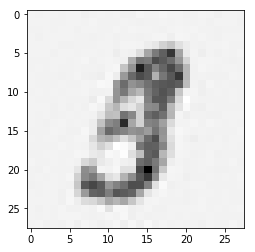

31 [[-0.37395528 -0.16024469 -0.47034135  0.38275534  0.68683016]]


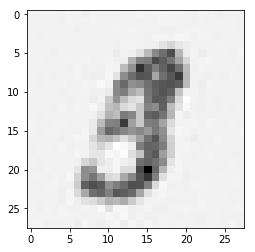

32 [[-0.36247849 -0.20142151 -0.391298    0.38063914  0.64300752]]


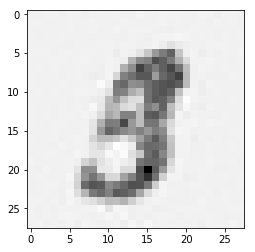

33 [[-0.34842765 -0.2419928  -0.31111503  0.38041088  0.60144812]]


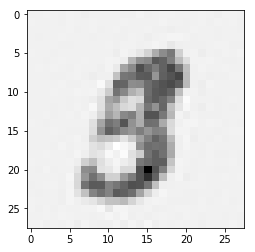

34 [[-0.33795047 -0.282884   -0.23348802  0.37923706  0.55464208]]


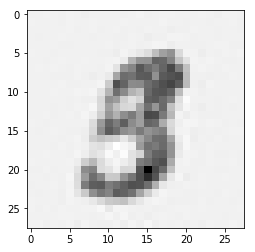

35 [[-0.33266351 -0.31592581 -0.1508361   0.37837029  0.50938511]]


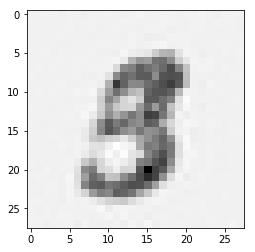

36 [[-0.32417959 -0.35728702 -0.07150029  0.38503915  0.46604198]]


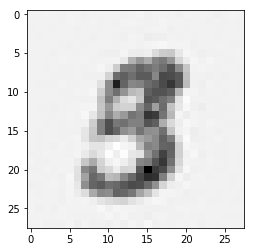

37 [[-0.30532289 -0.39020669  0.005665    0.38746855  0.41504851]]


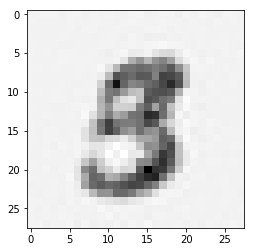

38 [[-0.2904484  -0.42196178  0.08401478  0.38265669  0.36397481]]


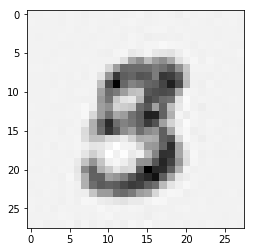

39 [[-0.27714807 -0.4459123   0.16711232  0.38273898  0.31555718]]


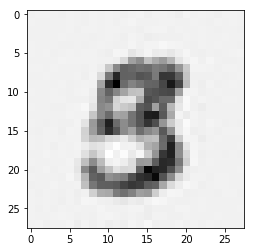

40 [[-0.25921884 -0.4667052   0.24382232  0.3753376   0.25805074]]


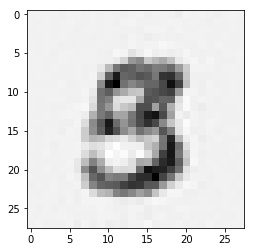

41 [[-0.25144514 -0.48440564  0.3199195   0.36267889  0.19742697]]


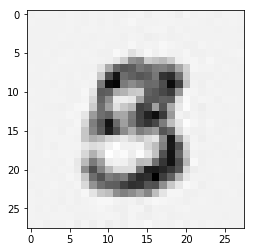

42 [[-0.24443732 -0.49727374  0.39517319  0.34724966  0.13510425]]


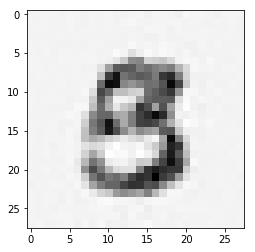

43 [[-0.24070883 -0.50683737  0.46891859  0.33213413  0.07008294]]


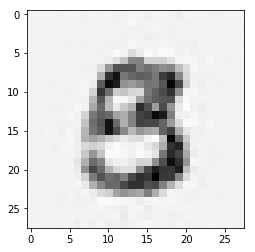

44 [[-0.23017906 -0.51311004  0.54103935  0.3039434   0.00800513]]


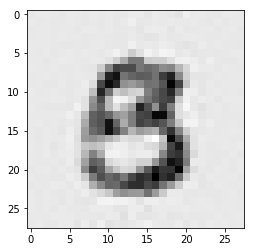

45 [[-0.22034699 -0.51568896  0.61327386  0.26906428 -0.05083616]]


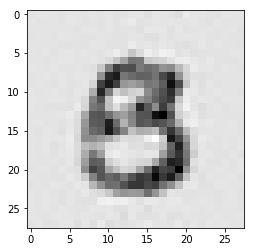

46 [[-0.20859811 -0.50691086  0.6925354   0.24375817 -0.10433497]]


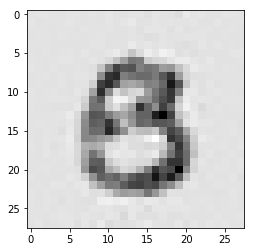

47 [[-0.21054536 -0.48399884  0.7647894   0.21145816 -0.16096815]]


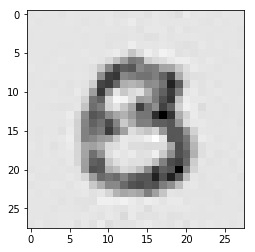

48 [[-0.20411173 -0.4686937   0.82369363  0.15548161 -0.21683657]]


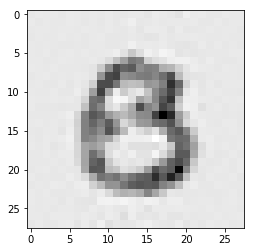

49 [[-0.19298272 -0.44111741  0.87024903  0.09202249 -0.27088496]]


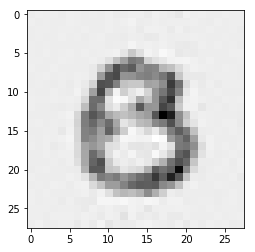

50 [[-0.16972058 -0.40687546  0.91807586  0.04119268 -0.32932544]]


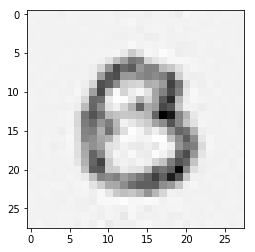

51 [[-0.15067047 -0.36984351  0.95239085 -0.00322719 -0.40084526]]


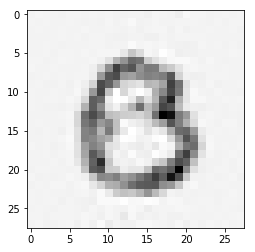

52 [[-0.11954575 -0.33426017  0.97470093 -0.04291312 -0.47629303]]


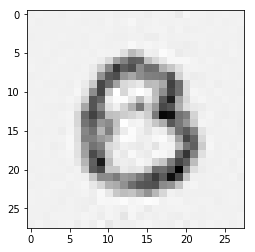

53 [[-0.08717664 -0.31602958  0.97776526 -0.09738986 -0.55141145]]


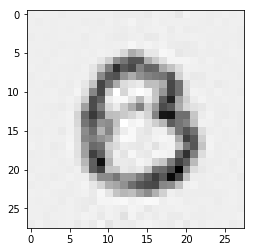

54 [[-0.05280305 -0.3053571   0.97351891 -0.160577   -0.61992353]]


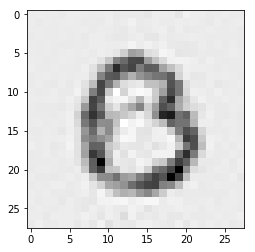

55 [[-0.01906943 -0.29844281  0.95597094 -0.22960576 -0.68109   ]]


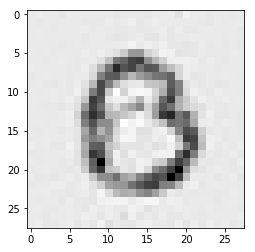

56 [[ 0.03456993 -0.27245957  0.93402761 -0.28622755 -0.7336272 ]]


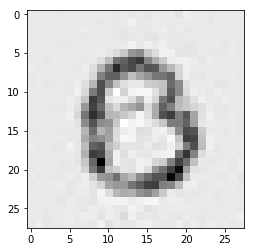

57 [[ 0.09462625 -0.25046471  0.88367051 -0.33211797 -0.76923192]]


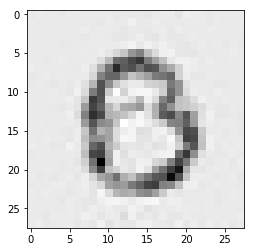

58 [[ 0.14447114 -0.25201648  0.82553232 -0.3843185  -0.80675703]]


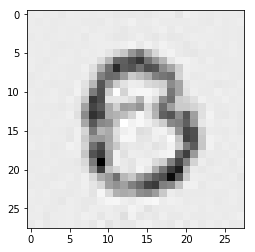

59 [[ 0.21467309 -0.23180325  0.77264488 -0.42527077 -0.79301131]]


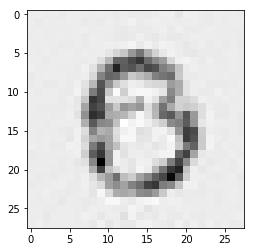

60 [[ 0.24905205 -0.22314312  0.68192023 -0.447826   -0.79116905]]


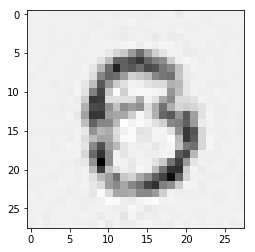

61 [[ 0.22036786 -0.19828832  0.59217298 -0.46111569 -0.77305084]]


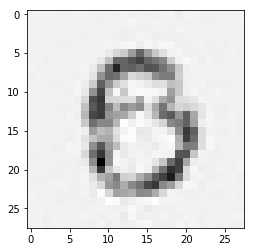

62 [[ 0.19485933 -0.17991884  0.49862343 -0.46636888 -0.75779432]]


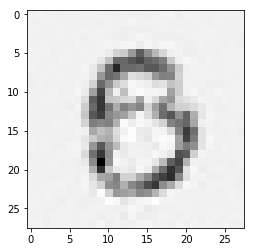

63 [[ 0.16955169 -0.16155003  0.40465793 -0.46303666 -0.74432236]]


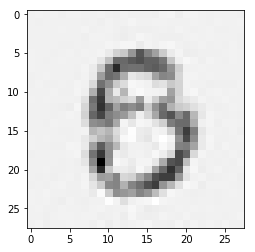

64 [[ 0.13557588 -0.14565964  0.31297621 -0.46338609 -0.7306301 ]]


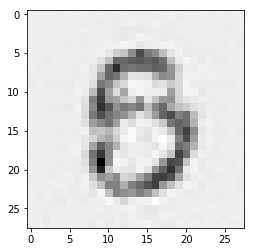

65 [[ 0.10156327 -0.12161968  0.2240063  -0.47241905 -0.7142598 ]]


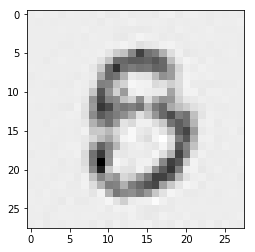

66 [[ 0.07083803 -0.09699466  0.13403127 -0.47776538 -0.69621879]]


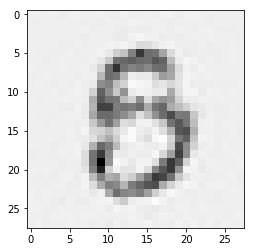

67 [[ 0.04190786 -0.07112911  0.04339115 -0.47841385 -0.67954648]]


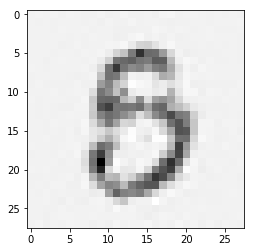

68 [[ 0.0205239  -0.0509217  -0.05082763 -0.47476935 -0.66392833]]


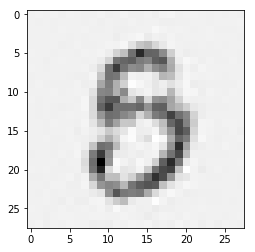

69 [[ 0.00315738 -0.02832195 -0.14322613 -0.4748835  -0.63843012]]


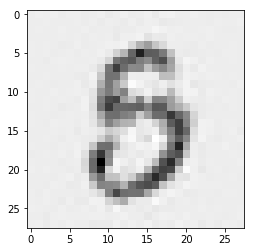

70 [[-0.01577207 -0.00556975 -0.23576421 -0.46973783 -0.61531651]]


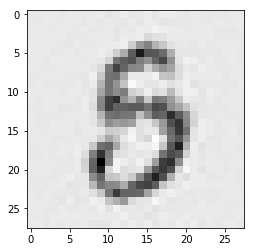

71 [[-0.03174377  0.0192614  -0.32761031 -0.46158436 -0.59029382]]


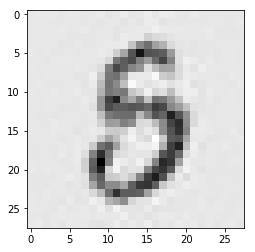

72 [[-0.03972601  0.04919329 -0.41878572 -0.45249668 -0.5649004 ]]


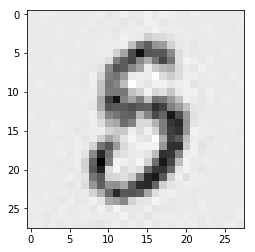

73 [[-0.04183836  0.06972274 -0.50824451 -0.44348893 -0.52629912]]


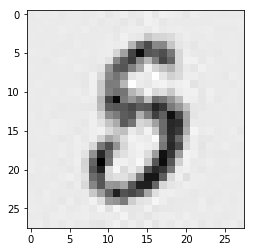

74 [[-0.04593046  0.10021991 -0.59370202 -0.43346745 -0.48568189]]


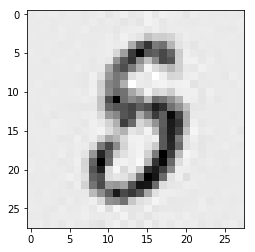

75 [[-0.04455049  0.12616888 -0.67820382 -0.42359093 -0.44000205]]


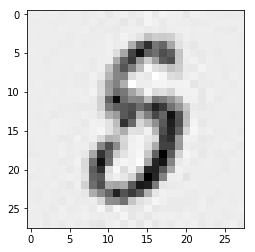

76 [[-0.04594036  0.14656544 -0.76619244 -0.41647252 -0.39770103]]


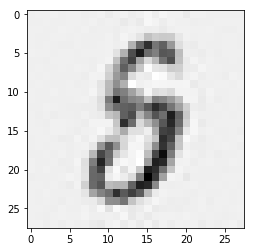

77 [[-0.04828588  0.17556626 -0.85180902 -0.40271333 -0.357279  ]]


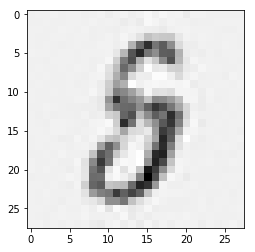

78 [[-0.04673686  0.20642507 -0.92825079 -0.37250432 -0.30943131]]


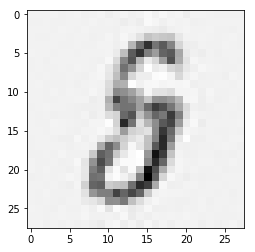

79 [[-0.0434269   0.22581805 -1.00443637 -0.33557624 -0.25998408]]


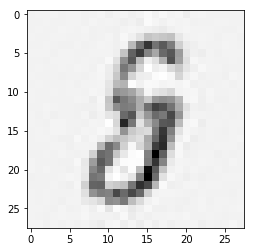

80 [[-0.03683667  0.25698289 -1.0730269  -0.29031858 -0.21273577]]


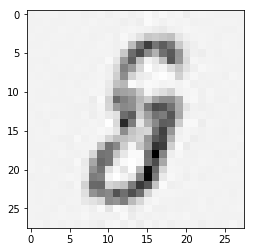

81 [[-0.0268718   0.29206488 -1.12945414 -0.23440272 -0.16416271]]


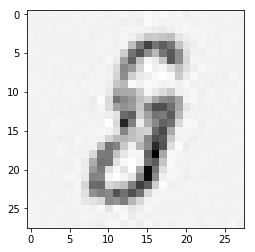

82 [[-0.02318216  0.33894148 -1.14987206 -0.17158109 -0.10563478]]


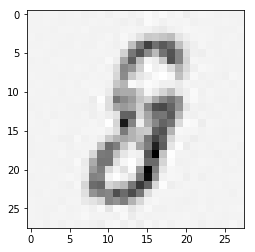

83 [[ -7.13191926e-04   3.92734408e-01  -1.15486479e+00  -1.19506001e-01
   -4.34678532e-02]]


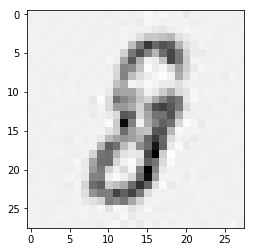

84 [[ 0.01430165  0.43984681 -1.14903712 -0.06549743  0.02438557]]


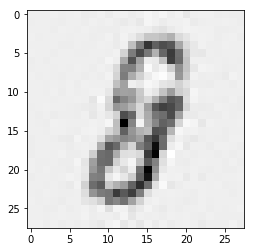

85 [[ 0.02691793  0.48877904 -1.1328454  -0.01134675  0.08959292]]


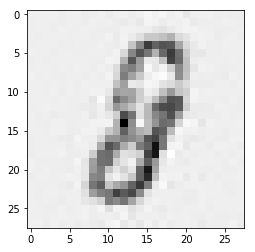

86 [[ 0.03935004  0.53355223 -1.10674679  0.04752259  0.15037176]]


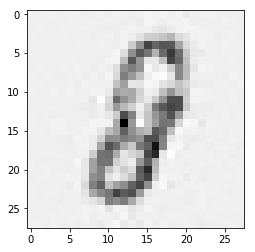

87 [[ 0.05414893  0.58189481 -1.07624722  0.10186467  0.2100434 ]]


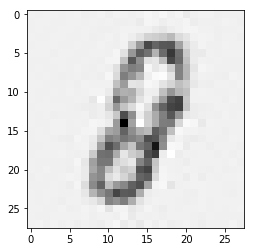

88 [[ 0.06361438  0.63897705 -1.05189824  0.15266016  0.26902613]]


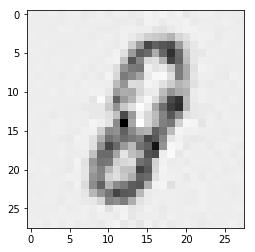

89 [[ 0.08669221  0.67590988 -1.01476657  0.20731406  0.33016187]]


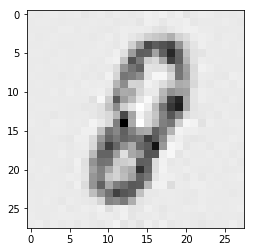

90 [[ 0.11448904  0.70877051 -0.95379508  0.25737622  0.37402269]]


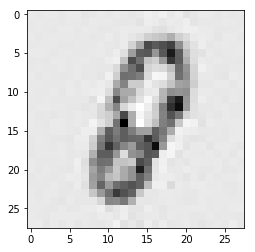

91 [[ 0.12896581  0.74093962 -0.8779217   0.29765117  0.411127  ]]


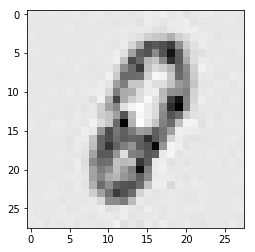

92 [[ 0.15473992  0.76250207 -0.79471165  0.31847122  0.45002908]]


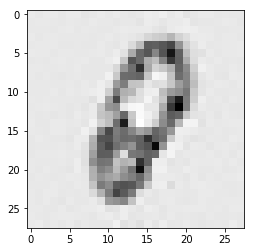

93 [[ 0.18099447  0.77836472 -0.70614332  0.33906052  0.47815031]]


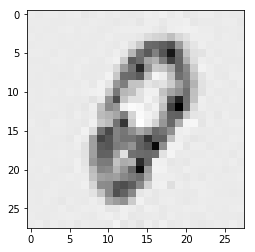

94 [[ 0.21114188  0.7840988  -0.61386967  0.34857774  0.4994399 ]]


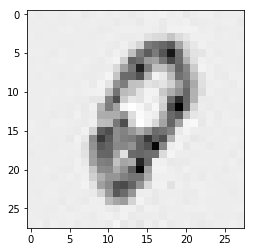

95 [[ 0.24514088  0.78730029 -0.52100468  0.3495594   0.51389486]]


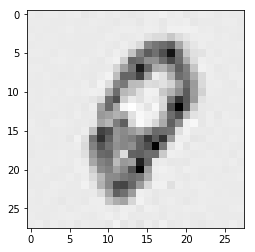

96 [[ 0.28548512  0.78226709 -0.43000114  0.346044    0.52117574]]


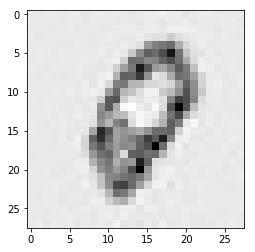

97 [[ 0.32028124  0.77938586 -0.33634186  0.3444643   0.5236994 ]]


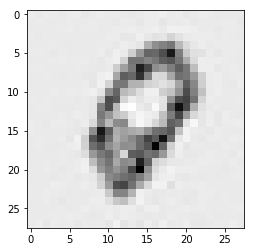

98 [[ 0.36674333  0.7710827  -0.24910808  0.33722484  0.53419638]]


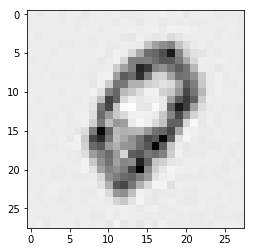

99 [[ 0.4144415   0.76181078 -0.16346487  0.32619932  0.54770917]]


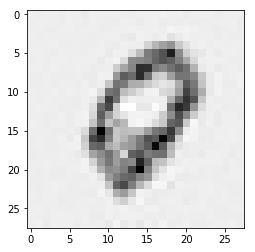

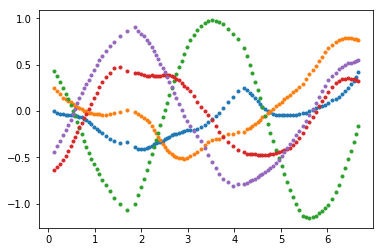

In [11]:
P = 100

H = 5
p = xp.random.uniform(-1,1,(1,nz),dtype=np.float32)
v = xp.random.uniform(-1,1,(1,nz),dtype=np.float32) 
sp = xp.sum(p**2)
sv = xp.sum(v**2)
#alp = xp.sqrt( (sp+sv-H)/sv + 1 )
alp = 1.0
v *= alp
dt = 0.1
t = 0

li = []
lt = []

for i in range(P):
    sdt = dt / xp.sqrt(xp.sum(v**2))
    t += sdt
    p += sdt * v
    v += sdt * ( - 2 * p + xp.random.randn(nz) * 2 )
    v *= 0.99 
    li.append(cuda.to_cpu(p))
    lt.append(cuda.to_cpu(t))
    if 1 == 1 or i % 10 == 0:
        z = Variable(xp.random.uniform(-1,1,(1,nz),dtype=np.float32) * 1)
        z = Variable(p.astype(np.float32).reshape(1,-1))

        print (i,z.data)
        x = gen(z)
        _x = cuda.to_cpu(x.data[0].reshape(28,-1))
        plt.imshow(_x,cmap="Greys")
        if 1 == 0:
            pass
            #import  scipy.misc as sm
            #f = sm.imresize(_x,(256,256) , interp = 'bicubic')
            #plt.imsave("img4/{}.png".format(i),_x,cmap="Greys")
        plt.show()
    
li = np.array(li).reshape(-1,5)
lt = np.array(lt).reshape(-1)
plt.plot(lt,li,".")